In [12]:
# Import modules and make matplotlib plot inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib inline  

# 1. Set up MCMC for line fitting problem in Session 1

Here, we repeat the line-fitting problem from Session 1. See the notebook in Session 1 to learn more about this implementation.

Load data

In [2]:
x,y,y_err = np.loadtxt('sample_data_from_S1.csv',delimiter=',',unpack=True)

Define functions needed for sampler

In [3]:
def compute_model(params,x):
    slope,intercept = params
    model_values = intercept + slope*x
    return model_values

def get_ln_like(params,x,y,yerr):
    model_y = compute_model(params,x)
    chi_squared = np.sum((y-model_y)**2.0 / y_err**2.0)
    ln_like = -0.5*chi_squared
    return ln_like

def get_ln_prior(params):
    slope, intercept = params
    
    # Compute prior from the slope parameter
    min_slope=0
    max_slope=15
    # Check if slope within above range
    if slope < min_slope or slope > max_slope: # Not in range, return ln(0)
        ln_prior_slope = -np.inf 
    else: # within range, return 1/(max-min)
        ln_prior_slope = np.log(1.0/(max_slope-min_slope))
    
    # Compute prior from the intercept parameter
    min_intercept=30
    max_intercept=70
    if intercept < min_intercept or intercept > max_intercept: # Not in range, return ln(0)
        ln_prior_intercept = -np.inf 
    else: # within range, return 1/(max-min)
        ln_prior_intercept = np.log(1.0/(max_intercept-min_intercept))
    
    # Compute the joint prior
    ln_prior = ln_prior_slope + ln_prior_intercept
    
    return ln_prior

def get_ln_post(params,x,y,yerr):
    # fill in your function here
    ln_like = get_ln_like(params,x,y,yerr)
    ln_prior = get_ln_prior(params)
    ln_post = ln_like + ln_prior
    return ln_post

Set up emcee's EnsembleSampler

In [4]:
# Set up the emcee sampler
ndim=2
nwalkers=100

# Construct the EnsembleSampler object using the posterior
sampler = emcee.EnsembleSampler(nwalkers, ndim, get_ln_post, args=[x,y,y_err])

# 2. Inspecting individual chains

The goal of MCMC is to generate samples that proportionally reflect the posterior probability space. However, if you do not have enough samples in the chain, and/or if you start too far away from the interesting part of the posterior (usually the peak) then you would not be exploring and sampling what you are likely hoping to sample. 

To check that we're sampling an interesting part of the posterior, we can inspect the individual walker chains.

## 2.1 A very short chain

First, let's see what happens when we have a really short chain. From Session 1, we knew that the most likely slope and intercept are 3.8 and 48, respectively. But what if we start a little bit away from this optimal location?

In [5]:
# Initital position of walkers away from most likely answer
p0_badguess = emcee.utils.sample_ball((15.0,35.0),(2.0,10),nwalkers)

Now let's run it for only a few steps

In [6]:
sampler.reset() # In case you're repeating this, make sure we start from scratch each time
pos, lnprob, rstate = sampler.run_mcmc(p0_badguess,50); # storing final position and probabilities to use later

//anaconda/envs/emcee_workshop/lib/python3.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
//anaconda/envs/emcee_workshop/lib/python3.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


We can inspect each walker using the `chain` attribute of `sampler`. Below, we look at one of the walkers and use the `sampler.chain` attribute to look at how the values for slope and intercept evolves as the walker explores posterior space. We can also use `sampler.lnprobability` to inspect the corresponding log posterior.

`sampler.chain` has shape `(walker,step,parameter)` and `sampler.lnprobability` has shape `(walker,step)`

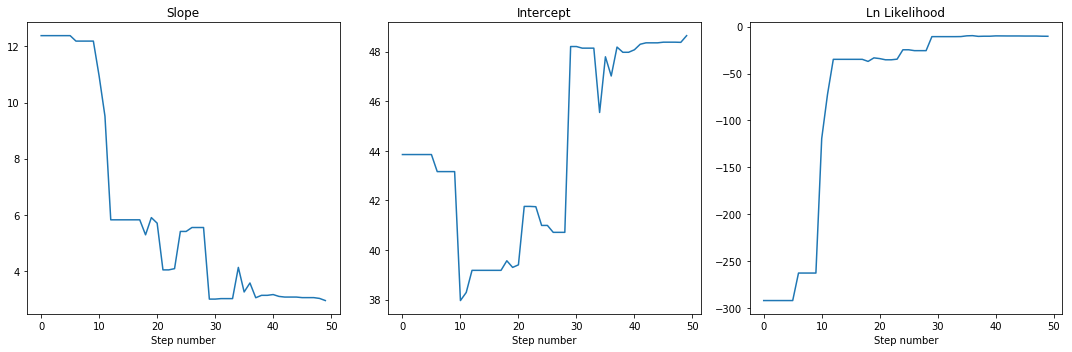

In [7]:
walker_to_inspect=0 # index of walker
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(sampler.chain[walker_to_inspect,:,0])
plt.title('Slope')
plt.xlabel('Step number')
plt.subplot(1,3,2)
plt.plot(sampler.chain[walker_to_inspect,:,1])
plt.title('Intercept')
plt.xlabel('Step number')
plt.subplot(1,3,3)
plt.plot(sampler.lnprobability[walker_to_inspect,:])
plt.title('Ln Posterior')
plt.xlabel('Step number')
plt.tight_layout()

Here, we see that the walkers are heading towards the best fit values but are just barely getting there. If we stop here and take the median values, we won't get the correct answer.

In [8]:
np.median(sampler.flatchain,axis=0)

array([ 6.86502156, 43.28635526])

## 2.2 A slightly longer chain

What if we run for another 50 steps? If we don't do a `sampler.reset()`, then the following will add another 50 steps to the chain.

In [9]:
pos, lnprob, rstate = sampler.run_mcmc(pos,50); # starting from the saved position

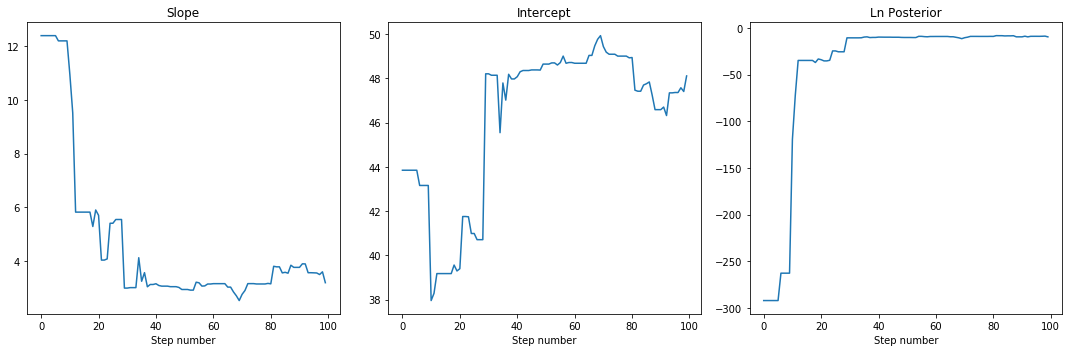

In [11]:
walker_to_inspect=0 # index of walker
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(sampler.chain[walker_to_inspect,:,0])
plt.title('Slope')
plt.xlabel('Step number')
plt.subplot(1,3,2)
plt.plot(sampler.chain[walker_to_inspect,:,1])
plt.title('Intercept')
plt.xlabel('Step number')
plt.subplot(1,3,3)
plt.plot(sampler.lnprobability[walker_to_inspect,:])
plt.title('Ln Posterior')
plt.xlabel('Step number')
plt.tight_layout()

Now we see that the additional steps are flucuating around the optimal values, suggesting that the walker has found a (local) maxima in posterior. The plot of the log posterior confirms that the later steps corresponds to a higher posterior probability.

Generally, when we see that the chains have parameters and log posteriors that are more-or-less monotonically changing (as in the first half), then we are likely not at a maxima and the walker is still trying to get there. We want to see small fluctuations around a specific value, as in the second half. 

But getting to the maxima is not enough. If we were to compute the median and make the corner plot, we won't get fair samples of the posteriors. Because the first half of the chains have not yet converged, the distributions calculated from these chains would be skewed (note the long tails).

In [24]:
print(np.median(sampler.flatchain,axis=0))
print(np.std(sampler.flatchain,axis=0))

[ 4.36655769 46.59819728]
[4.23428151 8.03973523]


<Figure size 432x288 with 0 Axes>

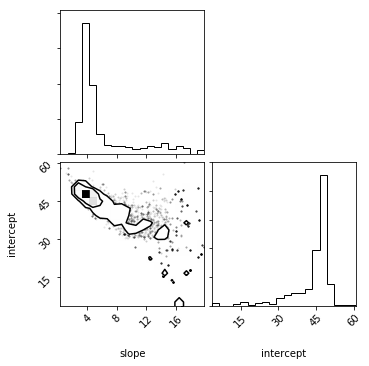

In [20]:
plt.figure()
corner.corner(sampler.flatchain, labels=['slope', 'intercept']);

## 2.3 Burn-in

"Burn-in" is a term to describe "burning" or discarding the first X samples in a chain to only get the well-mixed or "converged" part. At zeroth-order, you can do this by eye by inspecting the above plots. It looks like it takes about 40-50 steps to get to the converged values, so we can burn/discard the first 50 values.

In [29]:
steps_to_burn = 50
burned_chain = sampler.chain[:,50:,:] # reminder: shape is (walker,step,dim)
burned_flatchain = np.reshape(burned_chain,(-1,ndim)) # reshape to (steps_across_all_walkers,dim)
burned_lnpost = sampler.lnprobability[:,50:] # reminder: shape is (walker,step)

Now, we only have the last 50 steps of each of the 100 chains (5000 steps total). Let's look at the median/stddev and the corner plot.

In [31]:
print(np.median(burned_flatchain,axis=0))
print(np.std(burned_flatchain,axis=0))

[ 3.88877795 47.56386964]
[1.64599046 5.0961744 ]


<Figure size 432x288 with 0 Axes>

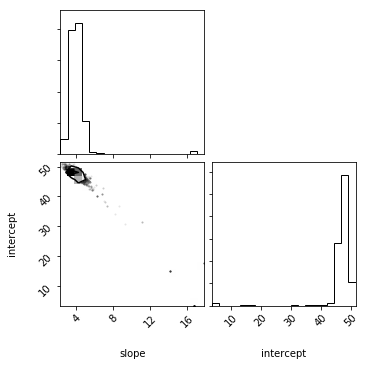

In [33]:
plt.figure()
corner.corner(burned_flatchain, labels=['slope', 'intercept']);

## 2.4 Choosing number of steps to burn

From the log posterior plots, the chains start at a very low posterior probability and then quickly converge to the values closer to the maxima. We can approximate this "approximate" value by computing the median log posterior value. In addition to the eyeballing method, we can say that the chain is well mixed when the chain's log posterior first rises above this median value. Here's an example for one walker.

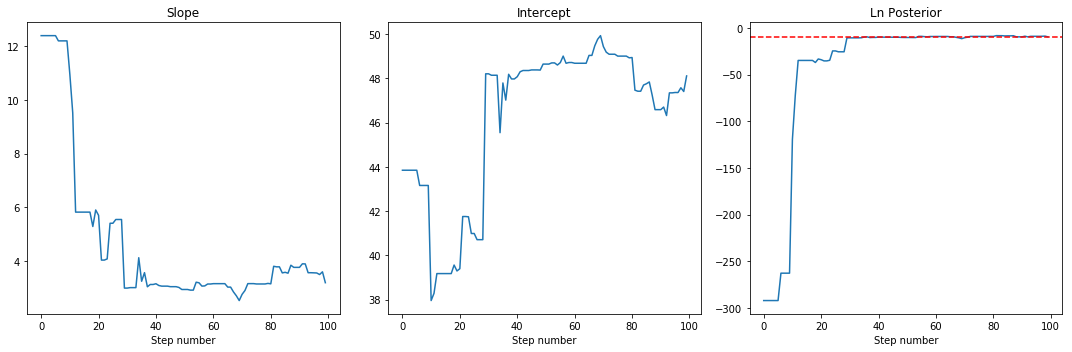

In [39]:
walker_to_inspect=0 # index of walker
median_lnpost = np.median(sampler.lnprobability[walker_to_inspect,:])
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(sampler.chain[walker_to_inspect,:,0])
plt.title('Slope')
plt.xlabel('Step number')
plt.subplot(1,3,2)
plt.plot(sampler.chain[walker_to_inspect,:,1])
plt.title('Intercept')
plt.xlabel('Step number')
plt.subplot(1,3,3)
plt.plot(sampler.lnprobability[walker_to_inspect,:])
plt.axhline(median_lnpost,color='red', linestyle='--')
plt.title('Ln Posterior')
plt.xlabel('Step number')
plt.tight_layout()

The dashed red line shows the median ln posterior value for this chain. To compute the first time the chain rises above this value, we can do something like:

In [45]:
np.argmax(sampler.lnprobability[walker_to_inspect,:] > median_lnpost)

35

Just to break this line down: The conditional statement inside the () returns `False` when the chain is below the median and `True` when it's above. In Python, `False` has a value of 0 and `True` has a value of 1. `np.argmax` is a function that returns the index of the maximum value of an array. Here, we have an array of just 0s and 1s, so the max value is 1. However, when there are more than one instance of the maximum value, `np.argmax` just returns the first one, which is what we want!

### Note: How to avoid having to burn samples

One easy way to avoid worrying about burn-in is to ensure your chains already start at the best fit value. MCMC is most powerful when used to explore parameter space, not just find the best fit value, so if you can find the best fit from some other method (See Session 1), then starting your walkers there would mean your chains would already have converged. You can and should still inspect the chains to ensure this is true.

## 2.5 Really long chains

Another way to minimize the effects of burn-in is to run a really long chain. In this example, if you have 5000 steps in each chain and only the first 50 are from the non-converged part of the chain, then this is only 1% of the chain and this might be small enough to not affect whatever problem you're trying to solve. Below, the example shows that you can get values that aren't as skewed (compare with the results from 100 steps before/after burning the first 50).

In [50]:
sampler.reset() # Reset our sampler
sampler.run_mcmc(p0_badguess,5000); # Now run for 5000 steps

In [51]:
print(np.median(sampler.flatchain,axis=0))
print(np.std(sampler.flatchain,axis=0))

[ 3.8397557  47.67008108]
[1.40356479 4.5768376 ]


<Figure size 432x288 with 0 Axes>

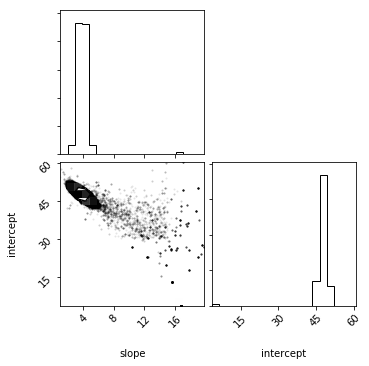

In [52]:
plt.figure()
corner.corner(sampler.flatchain, labels=['slope', 'intercept']);

The longer chains take a lot longer to run though, so it's far better to just start closer to the area of posterior space you want to explore and use MCMC for exploring posteriors rather than just finding best fits.

But if you do want to find best fits with MCMC, you can take a hybrid approach: First, run short chains just to get to the best fit value (e.g. in the 100-step example above). You can stop once you reach it and then start again closer to the best fit value to collect samples of the posterior. This is effectively a burn-in as well.

## 2.6 Auto-correlation time

`emcee` comes with a feature that computes the autocorrelation time $\tau$, which is a measure of the "clumpiness" of the MCMC chain. Although we would like each sample from MCMC to be independent from each other, but due to the way we propose and accept/reject steps, each step is dependent on the previous position. The autocorrelation time is an estimate of how many steps you need to take before the chain has "forgotten" where it started. To compute it within `emcee`, you need a large number of steps.

In [53]:
sampler.get_autocorr_time()

//anaconda/envs/emcee_workshop/lib/python3.7/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real
//anaconda/envs/emcee_workshop/lib/python3.7/site-packages/emcee/autocorr.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return acf / acf[m]
//anaconda/envs/emcee_workshop/lib/python3.7/site-packages/emcee/autocorr.py:105: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`

array([39.58751748, 44.01728507])

The result from `emcee` is the number of steps for each dimension/parameter necessary to get an independent measure of the parameter. The `emcee` tutorial shows that you can only measure this well if you have about 50 times as many steps as your measured/estimated autocorrelation time. Similarly, if you have N steps in your chain and autocorrelation time $\tau$, you can consider that you have $N/\tau$ truly independent samples. For more information, see the detailed tutorial from `emcee` documentation: https://emcee.readthedocs.io/en/latest/tutorials/autocorr/#autocorr

# 3.  Other ways to check that your MCMC chain is reasonable

## Similar results if you use different parts of the chain

If you have a long MCMC chain, you can randomly take different large chunks of it and check whether each chunk will give similar answers.

## Similar results if you start walkers in different initial locations

Also a good way to check that you didn't end up in a local maxima and haven't found the global maxima yet since you would only get there with more (potentially infinite) steps.

## Chain is longer than any repeating pattern that you can see and/or much longer than the autocorrelation time

Overall, while you may not need very many samples to explore the posterior and create the corner plot, running a lot of chains for a large number of steps is needed to verify and check that your MCMC results are correct.